## ARIMA

In [ ]:
 !pip install statsmodels yfinance pmdarima arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 17.0 MB/s 
     |████████████████████████████████| 902 kB 57.4 MB/s 
     |████████████████████████████████| 6.4 MB 55.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 9.8 MB 36.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pandas as pd

plt.style.use('seaborn-poster')
# plt.style.use('.matplotlibrc')

In [ ]:
from datetime import datetime
import yfinance as yf
  
start_date = datetime(2011,12,31)
end_date = datetime(2021,12,31)

df = yf.download(
    'MCD',
    start=start_date,
    end = end_date
)

df_month = df.resample('M').last()


[*********************100%***********************]  1 of 1 completed


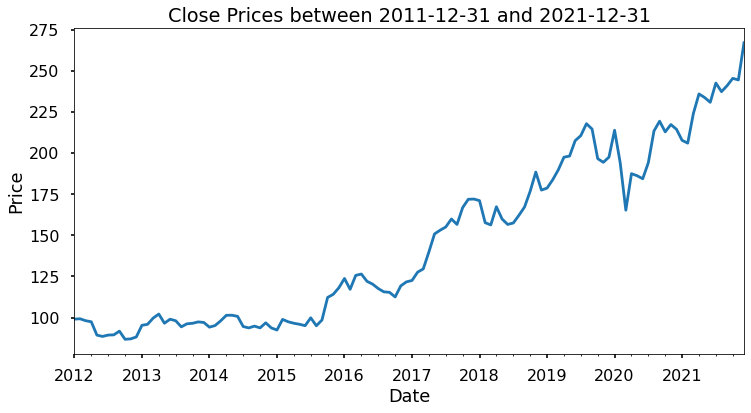

In [ ]:
plt.figure(figsize = (12, 6))
plt.title('Close Prices between {} and {}'.format(
    start_date.date().isoformat(),
    end_date.date().isoformat()
))
df_month['Close'].plot()
plt.ylabel('Price')
plt.xlabel('Date');

In [ ]:
df_month.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-31,99.040001,99.260002,98.250000,99.050003,74.187843,6574200
2012-02-29,99.860001,99.879997,99.260002,99.279999,74.882393,5461000
2012-03-31,97.879997,98.250000,97.760002,98.099998,73.992363,4429500
2012-04-30,97.610001,97.750000,97.089996,97.449997,73.502098,4507200
2012-05-31,89.889999,90.260002,89.260002,89.339996,67.912666,6816400


In [ ]:
df_month.index.freq

<MonthEnd>

In [ ]:
df_month=df_month.rename(columns={"Close": "Price"}, inplace=False)
df_month
MCD = df_month.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])
MCD

,Price
Date,
2012-01-31,99.050003
2012-02-29,99.279999
2012-03-31,98.099998
2012-04-30,97.449997
2012-05-31,89.339996
...,...
2021-08-31,237.460007
2021-09-30,241.110001
2021-10-31,245.550003


In [ ]:
import statsmodels.api as sm

#fig, axs = plt.subplots(2)
#sm.graphics.tsa.plot_pacf(MCD, lags=24, ax=axs[0])
#axs[0].set_ylabel('R')
#axs[0].set_xlabel('Lag')
#sm.graphics.tsa.plot_acf(MCD, lags=24, ax=axs[1]);
#axs[1].set_ylabel('R')
#axs[1].set_xlabel('Lag')
#fig.tight_layout()

Dickey–Fuller test: p=0.996119


<Figure size 1800x1440 with 0 Axes>

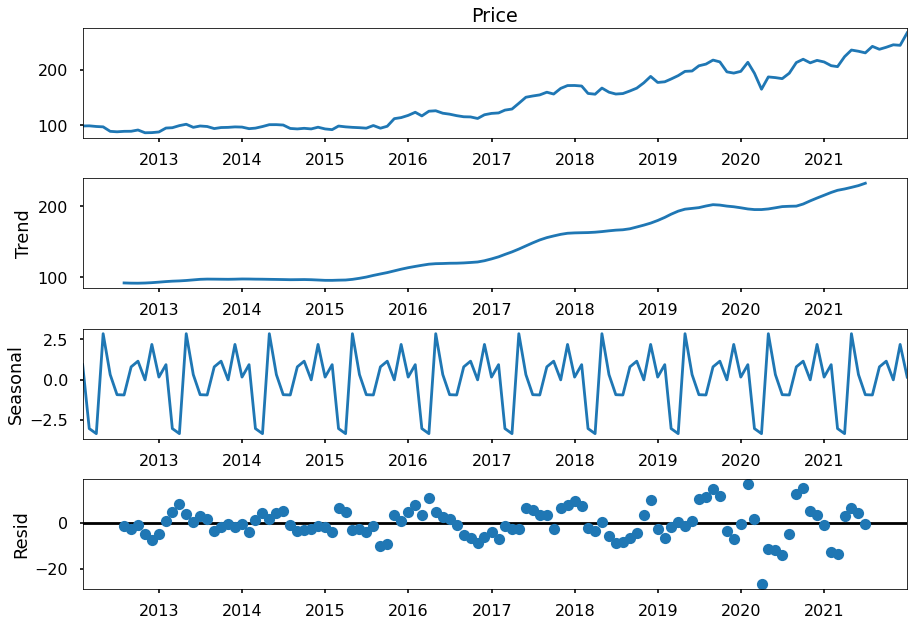

In [ ]:
plt.figure(figsize=[25,20])
sm.tsa.seasonal_decompose(MCD.Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(MCD.Price)[1])
plt.show()

# Finding a value for d

We are using the ARCH package which has more convenient versions of both the ADF and the KPSS tests.

In [ ]:
from arch.unitroot import KPSS, ADF

ADF(MCD.Price)

Test Statistic,1.220
P-value,0.996
Lags,6


Dickey–Fuller test: p=0.000156


<Figure size 3600x1800 with 0 Axes>

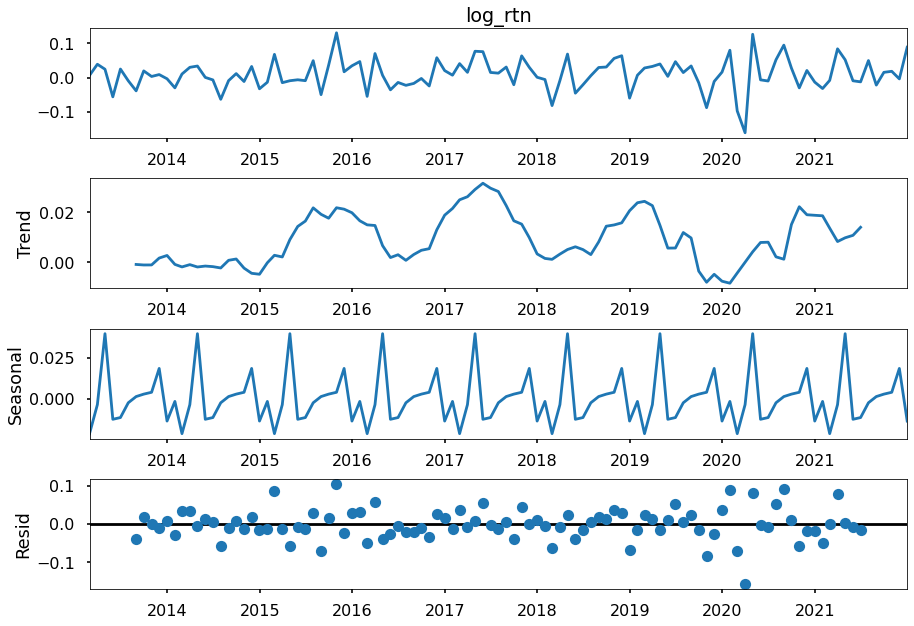

In [ ]:
# Seasonal differentiation
import numpy as np
MCD['log_rtn'] = np.log(MCD.Price/MCD.Price.shift(1))
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(MCD.log_rtn[13:])[1])

plt.figure(figsize=(50,25))

# STL-decomposition
sm.tsa.seasonal_decompose(MCD.log_rtn[13:]).plot()   

plt.show()

In [ ]:
MCD=MCD.dropna(axis=0)
MCD.isnull().sum()

Price      0
log_rtn    0
dtype: int64

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


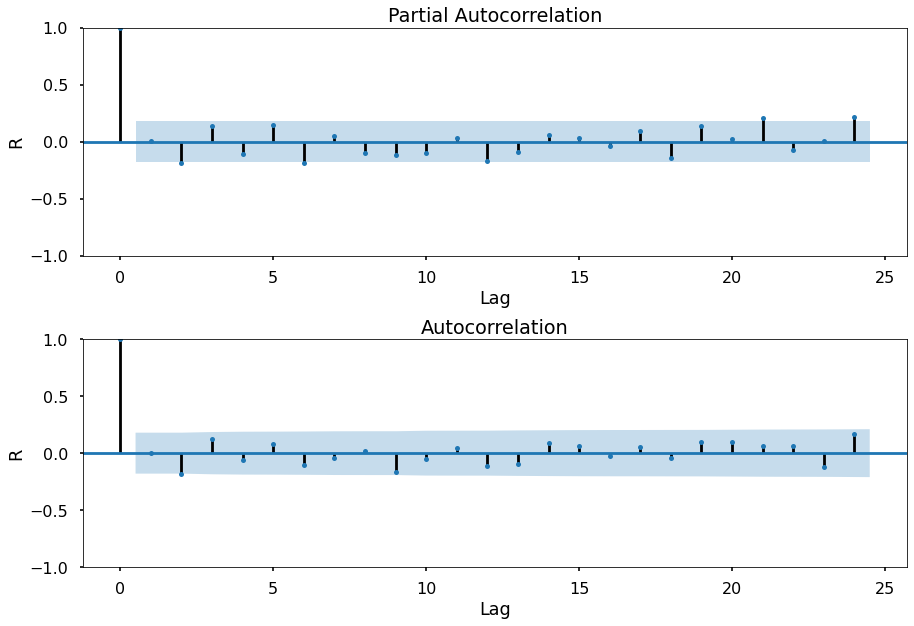

In [ ]:
import statsmodels.api as sm

fig, axs = plt.subplots(2)
sm.graphics.tsa.plot_pacf(MCD.log_rtn, lags=24, ax=axs[0])
axs[0].set_ylabel('R')
axs[0].set_xlabel('Lag')
sm.graphics.tsa.plot_acf(MCD.log_rtn, lags=24, ax=axs[1]);
axs[1].set_ylabel('R')
axs[1].set_xlabel('Lag')
fig.tight_layout()

In [ ]:
# Initial approximation of parameters
from itertools import product
import warnings 
warnings.filterwarnings('ignore')
import statsmodels.api as sm


Qs = range(0, 3)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(MCD.Price, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    
    bic = model.bic
    best_bic = bic   
    if bic < best_bic:
        best_model = model
        best_bic = bic
        best_param = param
    results.append([param, model.bic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'bic']
print(result_table.sort_values(by = 'bic', ascending=True).head())
bic_model=sm.tsa.statespace.SARIMAX(MCD.Price, order=(1,1,1), 
                                        seasonal_order=(1,1,1, 12)).fit(disp=-1)
print(bic_model.summary())

      parameters         bic
40  (1, 1, 1, 1)  752.357132
42  (1, 1, 2, 0)  752.871772
4   (0, 0, 1, 1)  754.051906
6   (0, 0, 2, 0)  754.146691
49  (1, 2, 1, 1)  754.496003
                                     SARIMAX Results                                      
Dep. Variable:                              Price   No. Observations:                  119
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -364.520
Date:                            Sun, 29 May 2022   AIC                            739.040
Time:                                    16:58:05   BIC                            752.357
Sample:                                02-29-2012   HQIC                           744.437
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000000


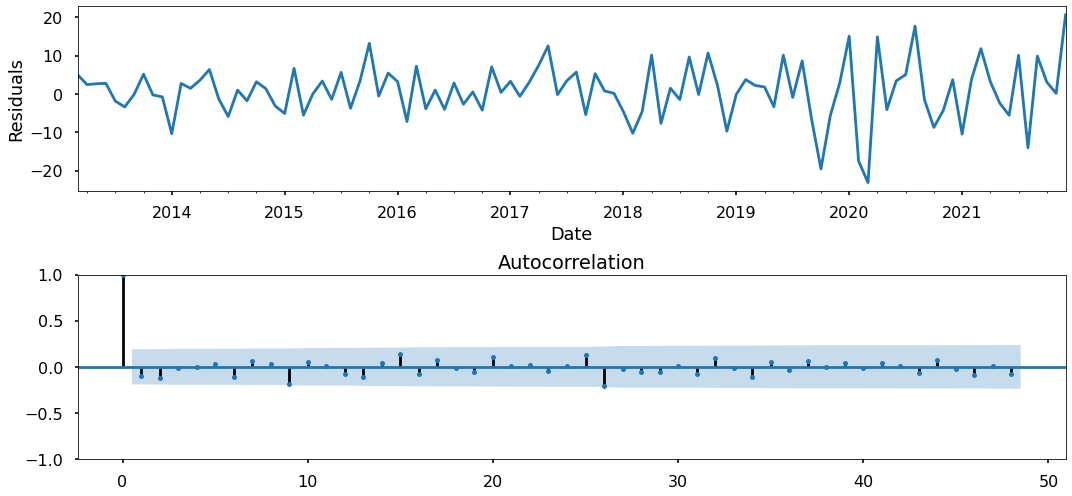

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
bic_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(bic_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(bic_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [ ]:
# Prediction
import numpy as np
MCD2 = MCD[['Price']]
date_list = [datetime(2022, 1, 31), datetime(2022, 2, 28), datetime(2022, 3, 31), datetime(2022, 4, 30), 
             datetime(2022, 5, 31), datetime(2022, 6, 30), datetime(2022, 7, 31), datetime(2022, 8, 31),
             datetime(2022, 9, 30),datetime(2022, 10, 31), datetime(2022, 11, 30),datetime(2022, 12, 31),
             datetime(2023, 1, 31), datetime(2023, 2, 28), datetime(2023, 3, 31), datetime(2023, 4, 30), 
             datetime(2023, 5, 31), datetime(2023, 6, 30), datetime(2023, 7, 31), datetime(2023, 8, 31),
             datetime(2023, 9, 30),datetime(2023, 10, 31), datetime(2023, 11, 30),datetime(2023, 12, 31)]
future = pd.DataFrame(index=date_list, columns= MCD2.columns)
MCD2 = pd.concat([MCD2, future])
MCD2['forecast'] = bic_model.predict(start=13, end=144)



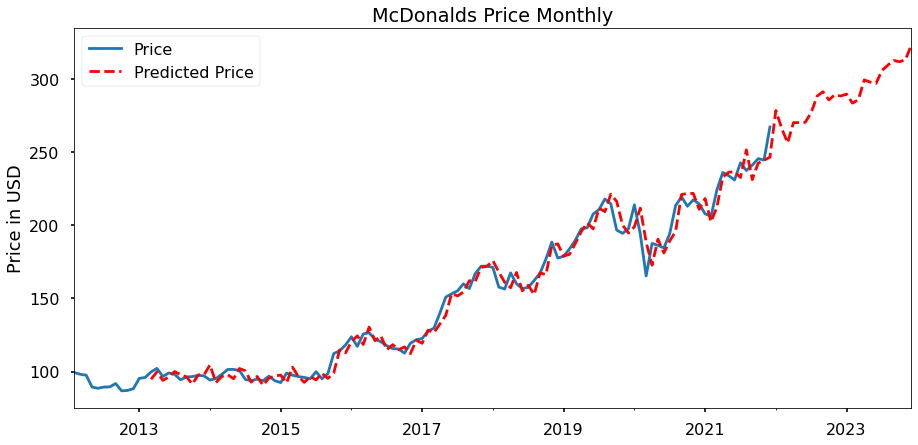

In [ ]:
plt.figure(figsize=(15,7))
MCD2.Price.plot()
MCD2.forecast.plot(color='r', ls='--', label='Predicted Price')
plt.legend()
plt.title('McDonalds Price Monthly')
plt.ylabel('Price in USD')
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import summary_table
predictions_int = bic_model.get_forecast(steps=24)
predictions_int.predicted_mean

2022-01-31    278.475737
2022-02-28    266.276322
2022-03-31    256.320876
2022-04-30    270.246093
2022-05-31    270.163348
2022-06-30    270.438982
2022-07-31    277.079528
2022-08-31    288.329099
2022-09-30    291.319465
2022-10-31    285.683975
2022-11-30    289.286647
2022-12-31    288.380258
2023-01-31    289.739267
2023-02-28    283.523321
2023-03-31    285.825129
2023-04-30    299.387693
2023-05-31    297.916354
2023-06-30    297.002923
2023-07-31    305.802307
2023-08-31    309.507392
2023-09-30    312.696305
2023-10-31    311.838992
2023-11-30    313.261531
2023-12-31    323.364819
Freq: M, Name: predicted_mean, dtype: float64

In [ ]:
predictions_int.conf_int()

,lower Price,upper Price
2022-01-31,264.647215,292.304259
2022-02-28,244.048846,288.503797
2022-03-31,229.601152,283.040600
2022-04-30,238.746349,301.745838
2022-05-31,235.123811,305.202885
2022-06-30,231.790096,309.087868
2022-07-31,235.394981,318.764075
2022-08-31,243.638081,333.020117
2022-09-30,243.932446,338.706483
2022-10-31,235.664113,335.703838


In [ ]:
conf_df = pd.concat([MCD['Price'],predictions_int.predicted_mean, predictions_int.conf_int()], axis = 1)

conf_df.head()

,Price,predicted_mean,lower Price,upper Price
2012-02-29,99.279999,NaN,NaN,NaN
2012-03-31,98.099998,NaN,NaN,NaN
2012-04-30,97.449997,NaN,NaN,NaN
2012-05-31,89.339996,NaN,NaN,NaN
2012-06-30,88.529999,NaN,NaN,NaN


In [ ]:
conf_df = conf_df.rename(columns={0: 'Predictions', 'lower MI': 'Lower CI', 'upper MI': 'Upper CI'})
conf_df.head()

,Price,predicted_mean,lower Price,upper Price
2012-02-29,99.279999,NaN,NaN,NaN
2012-03-31,98.099998,NaN,NaN,NaN
2012-04-30,97.449997,NaN,NaN,NaN
2012-05-31,89.339996,NaN,NaN,NaN
2012-06-30,88.529999,NaN,NaN,NaN


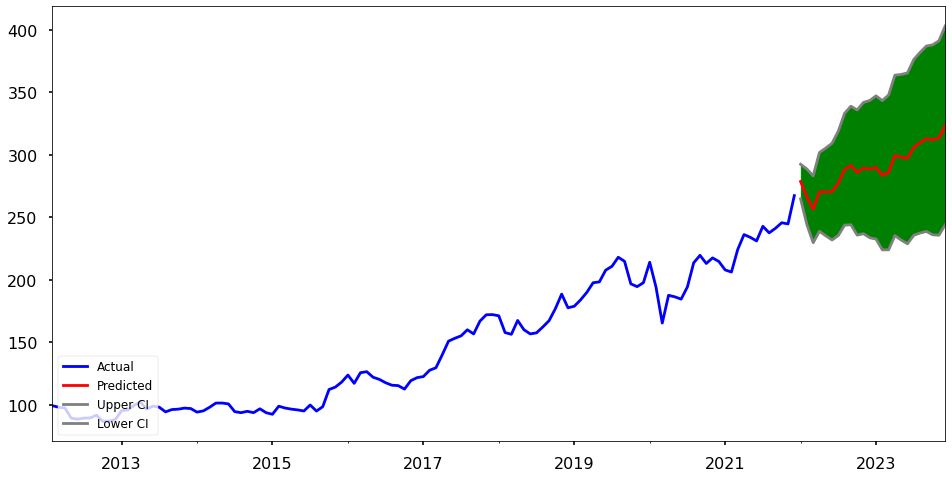

In [ ]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


x = conf_df.index.values


upper = conf_df['upper Price']
lower = conf_df['lower Price']

conf_df['Price'].plot(color = 'blue', label = 'Actual')
conf_df['predicted_mean'].plot(color = 'red',label = 'Predicted' )
upper.plot(color = 'grey', label = 'Upper CI')
lower.plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)


# fill between the conf intervals
plt.fill_between(x, lower, upper, color='green')


plt.show()

## VAR 


In [ ]:
VAR = yf.download(['MCD','XLP','VOO'],
                 start='2011-12-31',
                 end='2021-12-31',
                 progress=False)
VAR = VAR[['Close']]
VAR.columns = VAR.columns.droplevel(0)
VAR = VAR.rename(columns={'MCD': 'McDonalds', 'XLP': 'CStaples', 'VOO': 'S&P500'})
VAR_m = VAR.resample('M').last()

In [ ]:
VAR_m.head()

,McDonalds,S&P500,CStaples
Date,,,
2012-01-31,99.050003,120.040001,32.029999
2012-02-29,99.279999,125.180000,33.230000
2012-03-31,98.099998,128.740005,34.080002
2012-04-30,97.449997,127.919998,34.180000
2012-05-31,89.339996,120.239998,33.779999


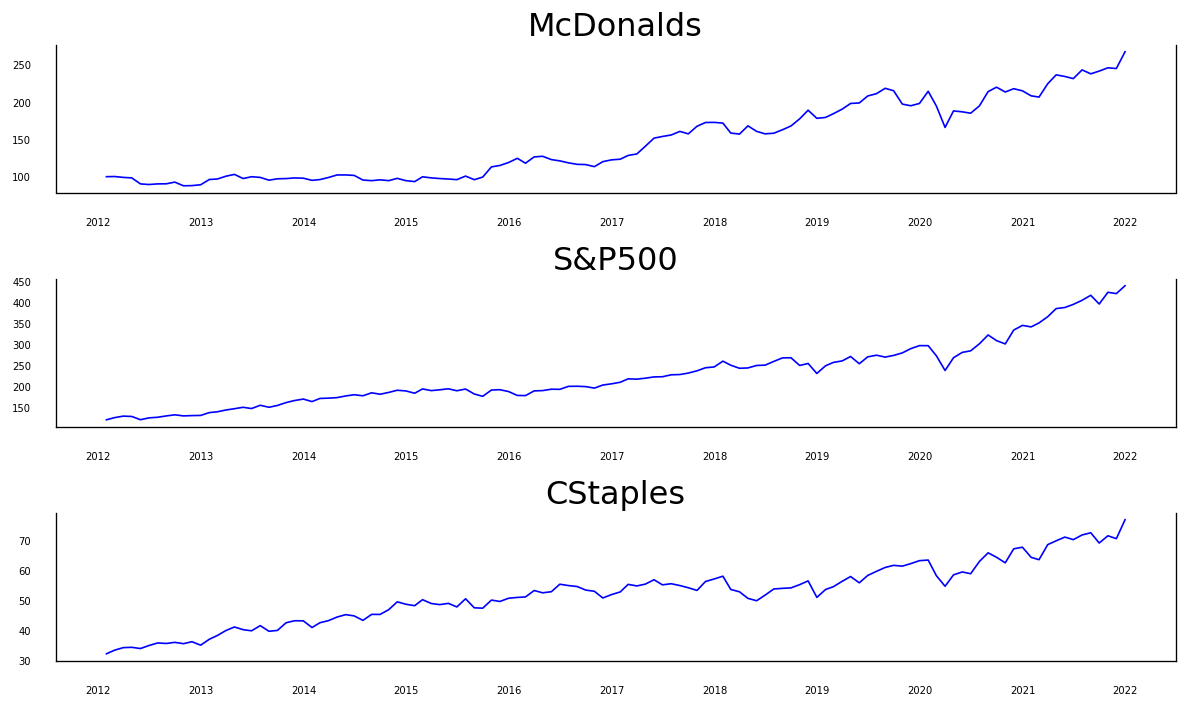

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = VAR_m[VAR_m.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(VAR_m.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    for c in VAR_m.columns:
        for r in VAR_m.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    VAR_m.columns = [var + '_x' for var in variables]
    VAR_m.index = [var + '_y' for var in variables]
    return VAR_m

grangers_causation_matrix(VAR_m, variables = VAR_m.columns)    

KeyError: ignored

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

ad_fuller_result_1 = adfuller(VAR_m['McDonalds'].diff()[1:])

print('McDonalds')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(VAR_m['S&P500'].diff()[1:])

print('S&P500')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

print('\n---------------------\n')

ad_fuller_result_3 = adfuller(VAR_m['CStaples'].diff()[1:])

print('CStaples')
print(f'ADF Statistic: {ad_fuller_result_3[0]}')
print(f'p-value: {ad_fuller_result_3[1]}')

In [ ]:
print('MCD causes CStaples?\n')
print('------------------')
granger_1 = grangercausalitytests(VAR_m[['McDonalds', 'CStaples']], 12)

print('MCD causes S&P500?\n')
print('------------------')
granger_2 = grangercausalitytests(VAR_m[['McDonalds', 'S&P500']], 12)

In [ ]:
model = VAR(VAR_m.diff()[1:])
sorted_order=model.select_order(maxlags=12)
print(sorted_order.summary())

In [ ]:
var_model = VARMAX(VAR_m, order=(1,1),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

In [ ]:
predict = fitted_model.get_forecast(steps=24)
predictions=predict.predicted_mean
predictions.columns=['McDonalds_p','S&P500_p','CStaples_p']
predictions

In [ ]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(111)


conf_df['Price'].plot(color = 'blue', label = 'Actual')
conf_df['predicted_mean'].plot(color = 'red',label = 'Arima' )
predictions['McDonalds_p'].plot(color = 'green',label = 'VAR' )

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)


plt.show()